# Libraries

In [3]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from afinn import Afinn


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

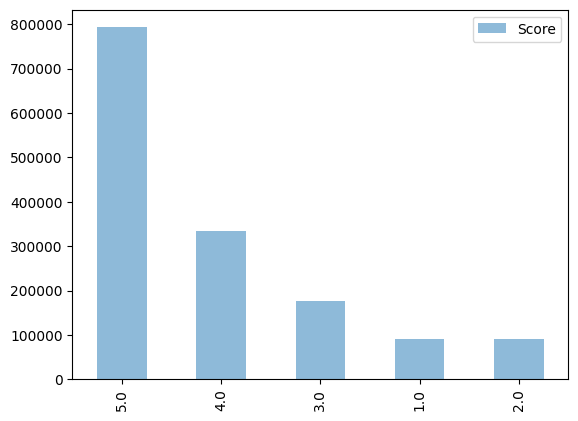


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [4]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

Helper Functions:

In [5]:
def textblob_sentiment_counts(text):
    # Split text into words
    words = text.split()
    
    # Initialize counters
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    # Get sentiment polarity for each word
    for word in words:
        word_polarity = TextBlob(word).sentiment.polarity
        
        if word_polarity > 0:
            positive_count += 1
        elif word_polarity < 0:
            negative_count += 1
        else:
            neutral_count += 1
    
    return positive_count, negative_count, neutral_count

# Adding Features

In [6]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    afinn = Afinn()
    # Calculate Helpfulness and handle missing values
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    mean_helpfulness = df['Helpfulness'].mean()
    df['Helpfulness'] = df['Helpfulness'].fillna(mean_helpfulness)
    
    # Ensure 'Text' is a string and fill missing values with an empty string
    df['Text'] = df['Text'].fillna('').astype(str)
    
    # Calculate the length of the comment in characters and words
    #df['CommentLength_Chars'] = df['Text'].apply(len)
    #df['CommentLength_Words'] = df['Text'].apply(lambda x: len(x.split()))
    
    # Add the average score for each ProductId directly into the original dataframe
    df['AverageMovieScore'] = df.groupby('ProductId')['Score'].transform('mean')
    # Fill missing values in AverageMovieScore with the overall mean of the 'Score' column
    df['AverageMovieScore'] = df['AverageMovieScore'].fillna(df['Score'].mean())

    # Add the average score for each ProductId directly into the original dataframe
    df['AverageUserScore'] = df.groupby('UserId')['Score'].transform('mean')
    # Fill missing values in AverageUserScore with the overall mean of the 'Score' column
    df['AverageUserScore'] = df['AverageUserScore'].fillna(df['Score'].mean())

    # Calculate how users rate certain products compared to the average score for that product.
    df['UserDeviationFromProductAvg'] = df['Score'] - df['AverageMovieScore']

    #df['SentimentScore'] = trainingSet['Text'].apply(afinn.score)

    # Min-Max normalization for selected columns
    scaler = MinMaxScaler()
    # Choose the columns you want to normalize
    columns_to_normalize = ['Helpfulness', 'AverageMovieScore', 'Time','AverageUserScore','UserDeviationFromProductAvg']
    #columns_to_normalize = ['Helpfulness', 'AverageMovieScore', 'AverageUserScore','UserDeviationFromProductAvg','SentimentScore']
    # Apply Min-Max scaling
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # Return the original DataFrame with features and the average score DataFrame
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [7]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [8]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness','AverageMovieScore','AverageUserScore']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [9]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=11).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

/Users/michaelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# Model Evaluation

Accuracy on testing set =  0.5793809380183984


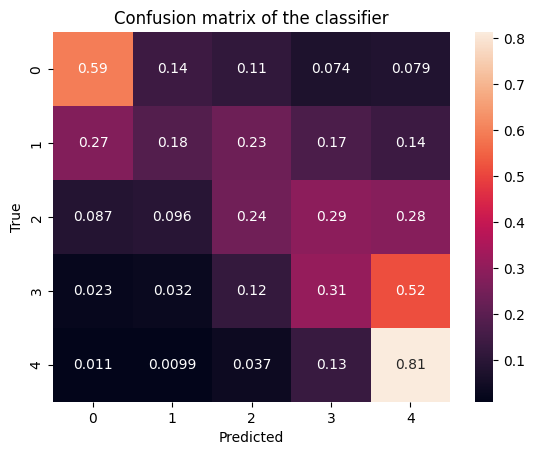

In [10]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [11]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

/Users/michaelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
